This is a Soft Actor Critic (SAC) implementation.

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

import gymnasium as gym

import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque

from model import ReplayBuffer
from torch.nn.utils import clip_grad_norm_

import time
from IPython.display import display, clear_output

In [2]:
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)
        

class Actor(nn.Module):
    def __init__(self, env=None):
        super().__init__()
        self.input_dim = env.observation_space.shape[0]             
        self.output_dim = env.action_space.shape[0]
        
        self.l1 = nn.Linear(self.input_dim, 400)
        self.l2 = nn.Linear(400, 300)
        
        self.mu = nn.Linear(300, self.output_dim)
        self.std = nn.Linear(300, self.output_dim)
        
        self.apply(weights_init_)

    def forward(self, x):
        a = F.relu(self.l1(x))
        a = F.relu(self.l2(a))
        
        mu = self.mu(a)
        # std = torch.clamp(F.softplus(self.std(a)), min=1e-6, max=5)
        log_std = torch.clamp(self.std(a), -20, 2)
        return mu, log_std

    def sample(self, obs, test=False):
        mu, log_std = self(obs)
        if test:
            return torch.tanh(mu)
        n = Normal(mu, log_std.exp())
        action = n.rsample().tanh()
        log_prob = (n.log_prob(action) - torch.log(1 - action.pow(2) + 1e-6)).sum(1)
        return action, log_prob


class Critic(nn.Module):
    def __init__(self, env=None):
        super().__init__()
        self.obs_dim = env.observation_space.shape[0]             
        self.action_dim = env.action_space.shape[0]
        input_dim = self.obs_dim + self.action_dim

        self.l1 = nn.Linear(input_dim , 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        
        self.apply(weights_init_)

    def forward(self, s, act):   
        a = torch.cat((s, act), dim=1)
        a = F.relu(self.l1(a))
        a = F.relu(self.l2(a))
        a = self.l3(a)
        return a.squeeze()

In [3]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

actor = Actor(env).to(device)
Q1 = Critic(env).to(device)
Q2 = Critic(env).to(device)

Q1_ = Critic(env).to(device)
Q2_ = Critic(env).to(device)

Q1_.load_state_dict(Q1.state_dict())
Q2_.load_state_dict(Q2.state_dict())

optim_a = torch.optim.Adam(actor.parameters(), lr=0.0001)
optim_q1 = torch.optim.Adam(Q1.parameters(), lr=0.00003)
optim_q2 = torch.optim.Adam(Q2.parameters(), lr=0.00003)

# Hyperparameters
gamma = 0.99
temp = 0.0003     # Temperature of the entropy term
train_ep_freq = 1
num_opt_steps = 1
eval_freq = 20
num_eval_ep = 10

# Loggers
rews_log = []
rews_eval_log = []
steps_log = []
loss_q1_log = []
loss_q2_log = []
loss_a_log = []

rb = ReplayBuffer(state_dim=env.observation_space.shape[0], 
                  action_dim=env.action_space.shape[0], 
                  length=1000000,
                  batch_size=256,
                  device=device)

In [4]:
def soft_update(target, source, tau=0.01):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + 
                                (1.0 - tau) * target_param.data)

In [13]:
def run_episode(test=False, render=False):
    obs, _ = env.reset()
    obs = (obs - env.observation_space.low) / (env.observation_space.high - env.observation_space.low) * 2 -1
    done = False
    rews_ep = []

    step = 0
    
    # Play the game and collect data
    while not done:
        if test:
            action = actor.sample(torch.tensor(obs).unsqueeze(0).to(device), test=True)
            # print(action)
        else:
            action = actor.sample(torch.tensor(obs).unsqueeze(0).to(device))[0]
        action = action[0].to('cpu').detach().numpy()
    
        obs_, reward, terminated, truncated, _ = env.step(action)
        obs_ = (obs_ - env.observation_space.low) / (env.observation_space.high - env.observation_space.low) * 2 -1
        done = terminated or truncated
        
        if not truncated:
            rb.store(obs, action, reward, obs_, terminated)
        obs = obs_
        
        rews_ep.append(reward)
        step += 1
        
        if render and step % 5 == 0:
                img = env.render()
                plt.imshow(img)
                plt.axis('off')  # Turn off axis
                display(plt.gcf())  # Display the current figure
                clear_output(wait=True)  # Clear the previous output
    return rews_ep, step

clip_value = 0.5

def optimize():
    s, a, r, s_, d = rb.sample()
    
    # Optimize the critics
    a_theta, log_prob = actor.sample(s_)
    q = torch.min(Q1_(s_, a_theta), Q2_(s_, a_theta)).to(device) 
    
    target = r + gamma * (1 - d) * (q - temp * log_prob)
    
    loss_q1 = F.mse_loss(Q1(s, a), target.detach())       #changed this
    loss_q2 = F.mse_loss(Q2(s, a), target.detach())

    Q1.zero_grad()      
    loss_q1.backward()     
    clip_grad_norm_(Q1.parameters(), clip_value)
    optim_q1.step()        
    
    Q2.zero_grad()
    loss_q2.backward()
    clip_grad_norm_(Q2.parameters(), clip_value)
    optim_q2.step()
    
    # Optimize the actor
    a_theta, log_prob = actor.sample(s)
    q = torch.min(Q1(s, a_theta), Q2(s, a_theta)).to(device)
    
    loss_a = -q.mean() - temp * log_prob.mean()
    
    actor.zero_grad()
    loss_a.backward()
    # break
    clip_grad_norm_(actor.parameters(), clip_value)
    optim_a.step()

    loss_q1_log.append(loss_q1.cpu().detach())
    loss_q2_log.append(loss_q2.cpu().detach())
    loss_a_log.append(loss_a.cpu().detach())
    
    soft_update(Q1_, Q1, tau=0.1)
    soft_update(Q2_, Q2, tau=0.1)

for episode in tqdm(range(400)):    
    rews_ep, step = run_episode()
    
    rews_log.append(sum(rews_ep))
    steps_log.append(step)

    if episode % eval_freq == 0:
        eval_rews = []
        for _ in range(num_eval_ep):
            rews_ep, step = run_episode(test=True)
            eval_rews.append(sum(rews_ep))
        rews_eval_log.append(sum(eval_rews) / len(eval_rews))

    if episode % train_ep_freq == 0:
        for opt_step in range(num_opt_steps):
            optimize()


100%|██████████| 400/400 [00:18<00:00, 22.07it/s]


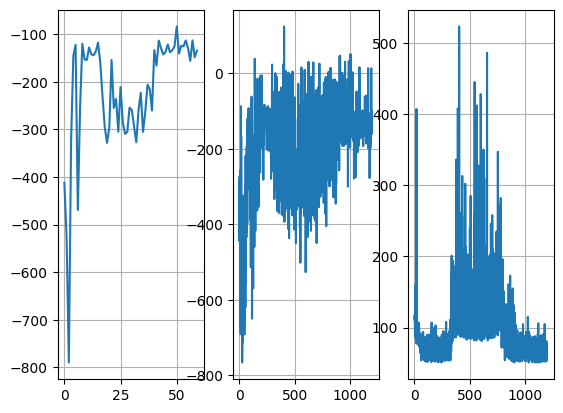

In [14]:
plt.subplot(1,3,1)
plt.plot(rews_eval_log)
plt.grid()
plt.subplot(1,3,2)
plt.plot(rews_log)
plt.grid()
plt.subplot(1,3,3)
plt.plot(steps_log)
plt.grid()
plt.show()

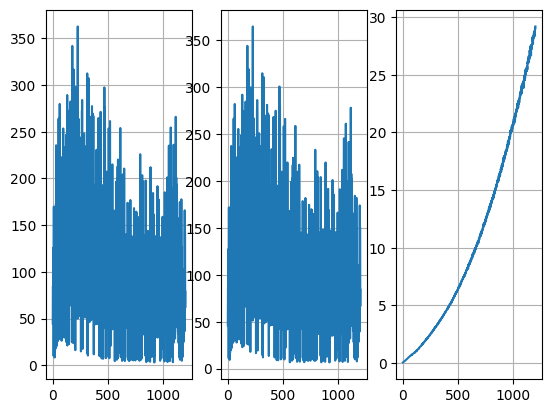

In [15]:
x = 0
plt.subplot(1,3,1)
plt.plot(loss_q1_log[x:])
plt.grid()
plt.subplot(1,3,2)
plt.plot(loss_q2_log[x:])
plt.grid()
plt.subplot(1,3,3)
plt.plot(loss_a_log[x:])
plt.grid()
plt.show()

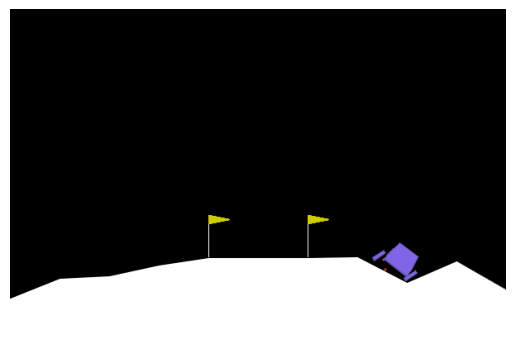

In [16]:
ep_rews, steps = run_episode(test=True, render=True)

In [9]:
sum(ep_rews)

-317.212858126828